# Coffee Data Notebook

Looking at different aspects of the data, mostly to improve collection and have more awareness.


In [1]:
import os

from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from optpresso import __file__ as optpresso_path
from optpresso.data.partition import find_test_paths

from IPython.core.display import display

In [2]:
# Modifiy this to point at the directory where all of the images live.
DATA_DIR = os.path.expanduser("~/coffee-images/train")
OPTPRESSO_DIR = os.path.dirname(optpresso_path)

images_by_time = defaultdict(list)
for time, img_path in find_test_paths(DATA_DIR):
    images_by_time[time].append(img_path)

### Data Distribution

The following graph presents the number of images associated with each pull time. Useful to determine where more data needs to be collected.

Spread of all data in /home/badisa/coffee-images/train
31.750613880153363


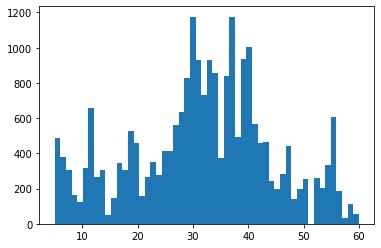

In [3]:
hist_data = []
for key, val in images_by_time.items():
    for _ in range(len(val)):
        hist_data.append(key)
plt.hist(hist_data, len(images_by_time))
print(f"Spread of all data in {DATA_DIR}")
print(np.mean(hist_data))

### Grinder/Pull Variation

The following looks at the variation seen in shot pull times at the same grind setting. Assumes a normal distribution of the shot times, which has yet to be confirmed.

In [4]:
# Clean up the CSV file.
df = pd.read_csv(os.path.join(OPTPRESSO_DIR, "..", "data", "coffee-collection.csv"))
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '').str.replace('(', '').str.replace(')', '')
df = df[df["grinder"].astype(bool)][df["grindersetting"].astype(bool)]
# Only care about data that has a grinder associated
invalid_indices = df[df["grinder"] == "None"].index
df.drop(invalid_indices, inplace=True)

::WARNING:: Distribution may not be normal, so take this with lots of salt
Fit func  
0.1027 x - 0.2302


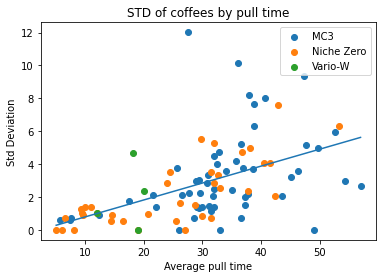

In [8]:
grouped = df.groupby(["grinder", "grindersetting", "coffee"])
df_mean = grouped.mean()
df_std = grouped.std().dropna()
x = defaultdict(list)
y = defaultdict(list)
for indice in df_std.index:
    if indice not in df_mean.index:
        continue
    grinder = indice[0]
    x[grinder].append(df_mean.time[indice])
    y[grinder].append(df_std.time[indice])
all_x = []
all_y = []
for grinder in x.keys():
    all_x.extend(x[grinder])
    all_y.extend(y[grinder])
    plt.scatter(x[grinder], y[grinder], label=grinder)
poly_fit = np.poly1d(np.polyfit(all_x, all_y, 1))
print("::WARNING:: Distribution may not be normal, so take this with lots of salt")
print("Fit func", poly_fit)
plt.plot(
    np.unique(all_x),
    poly_fit(np.unique(all_x))
)
plt.xlabel("Average pull time")
plt.ylabel("Std Deviation")
plt.title("STD of coffees by pull time")
plt.legend()
plt.show()

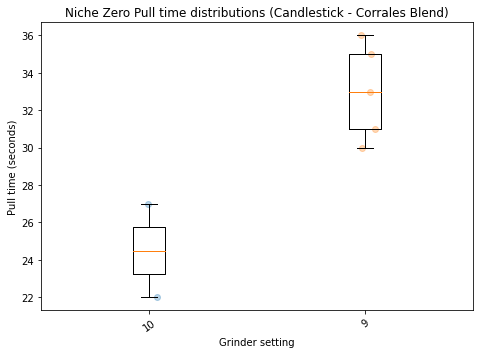

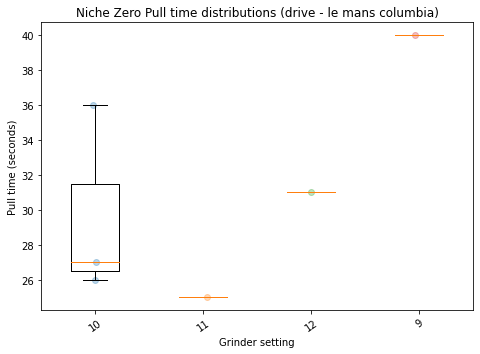

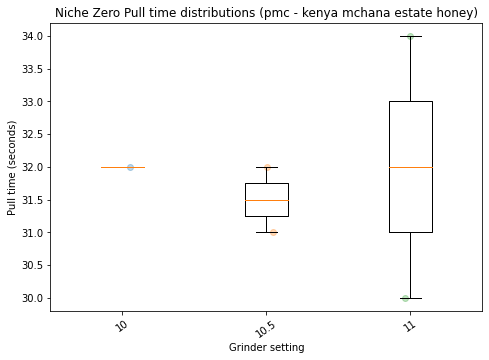

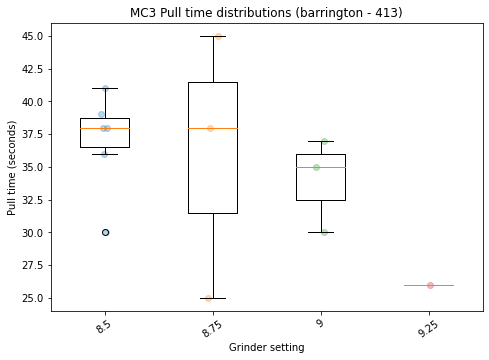

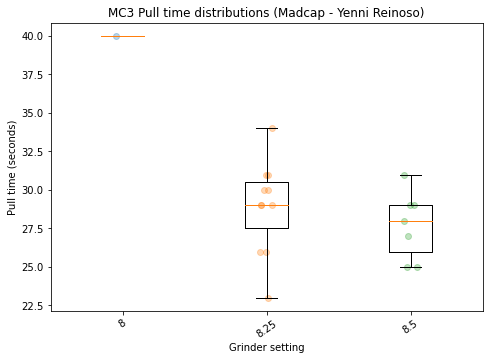

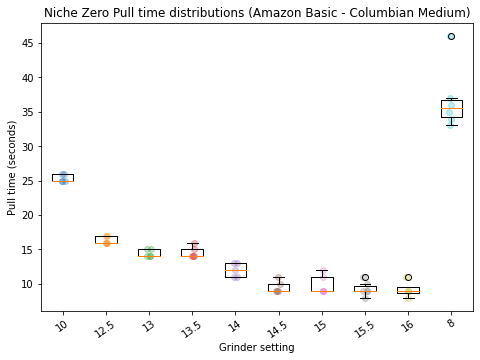

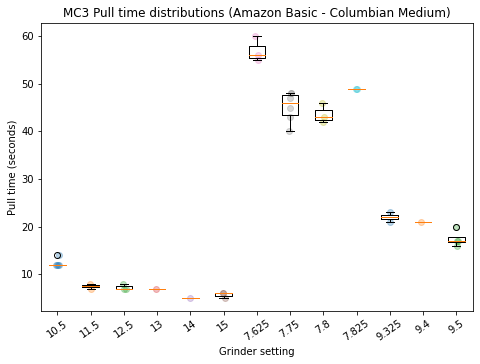

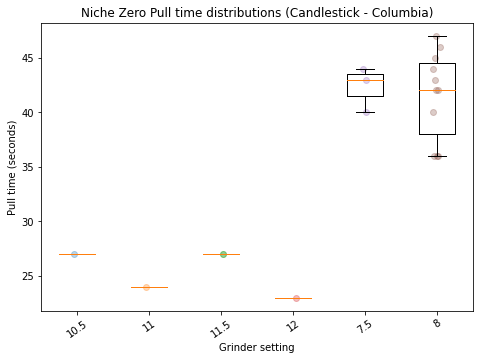

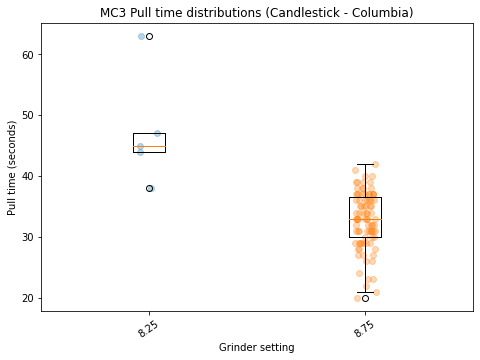

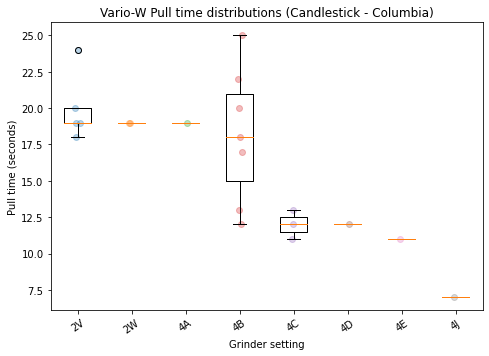

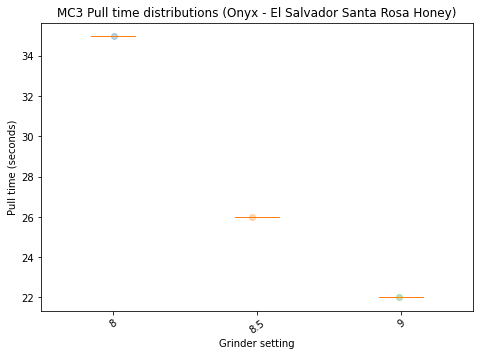

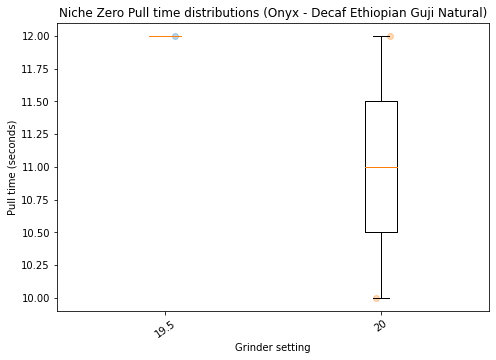

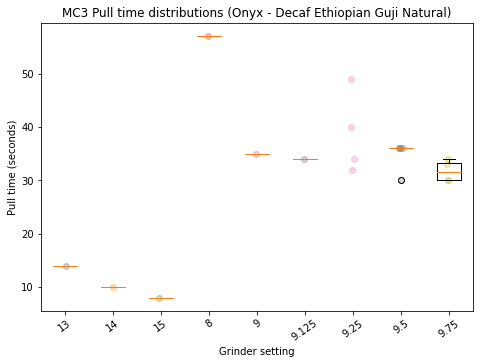

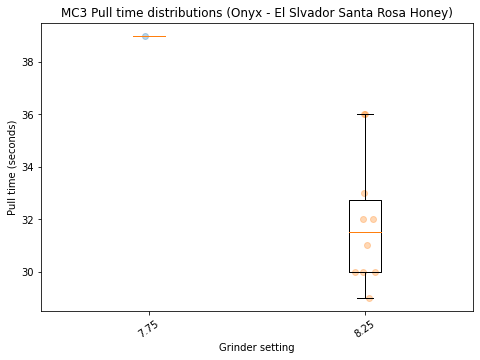

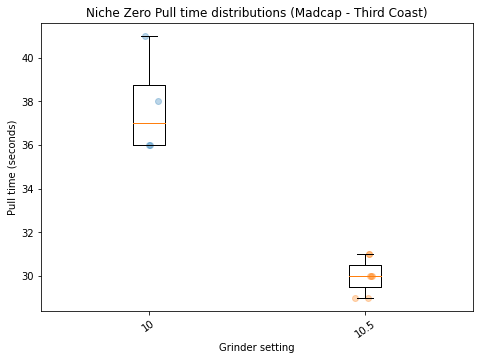

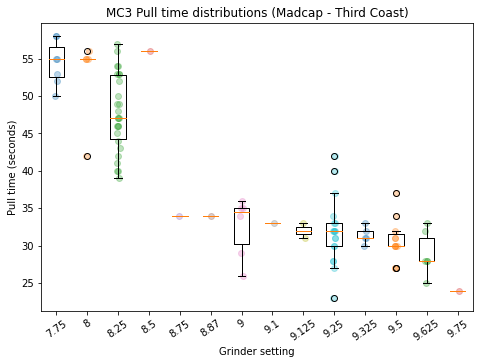

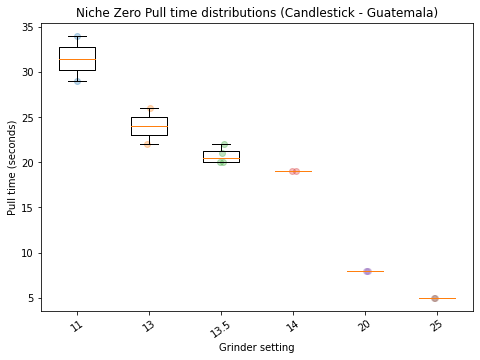

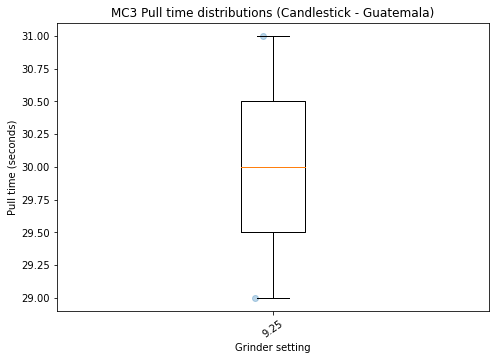

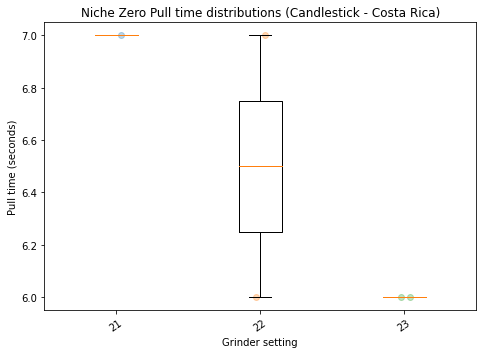

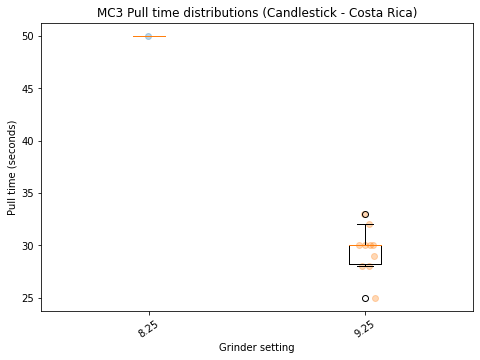

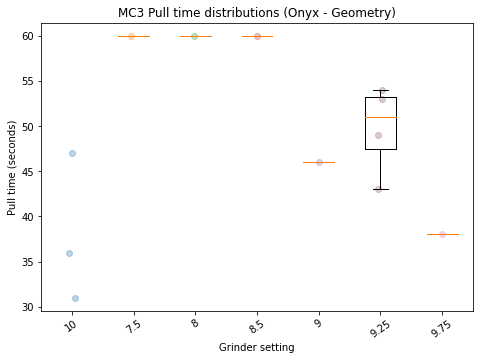

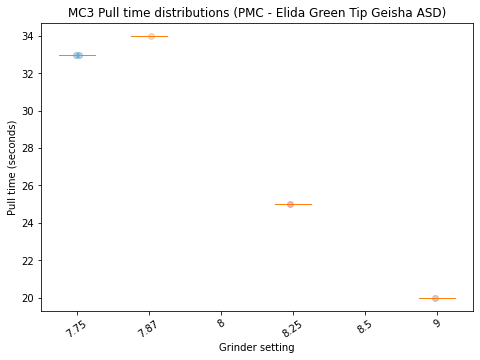

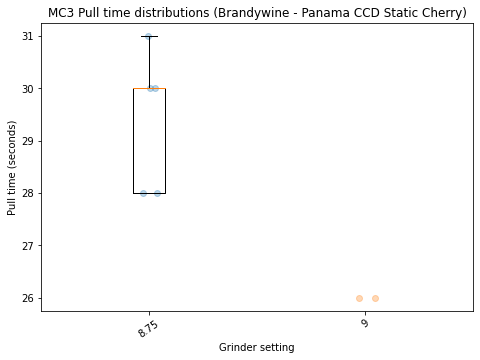

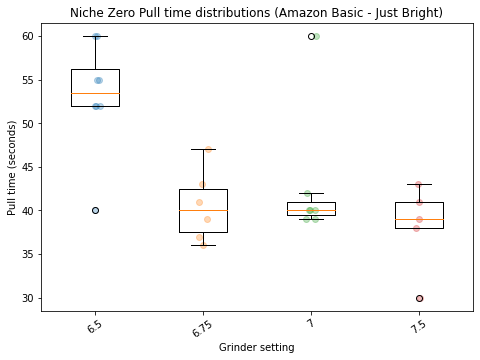

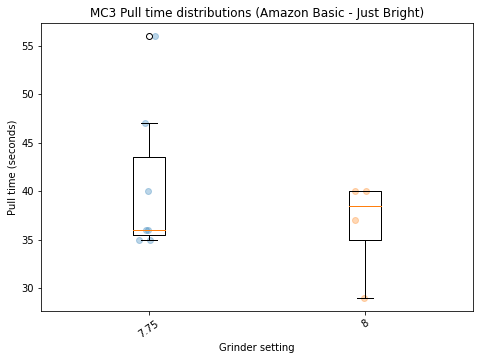

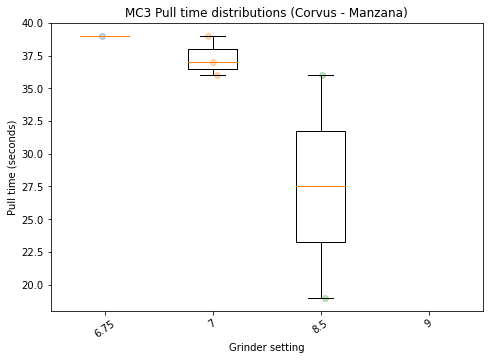

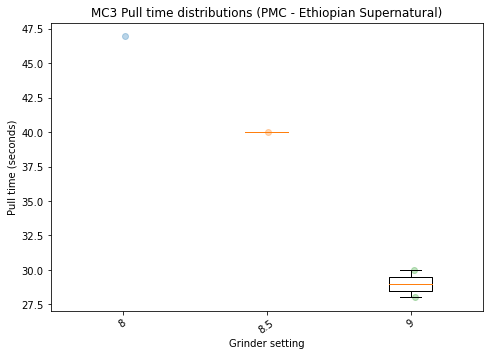

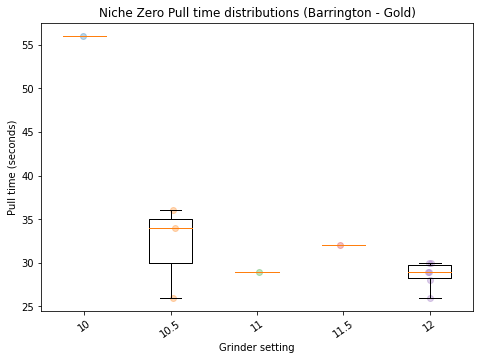

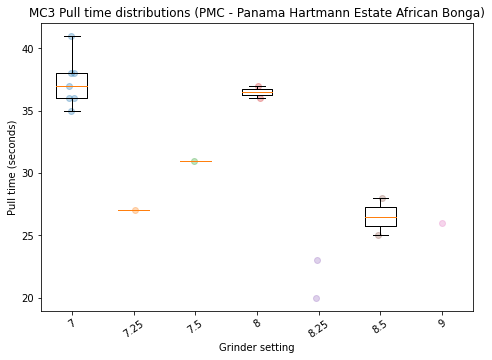

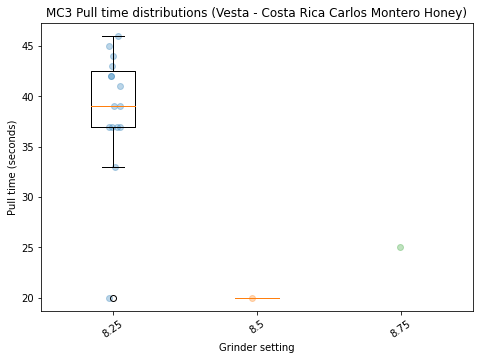

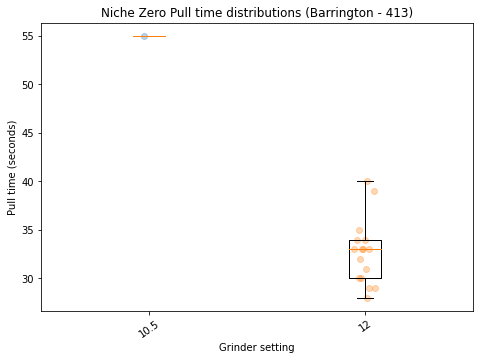

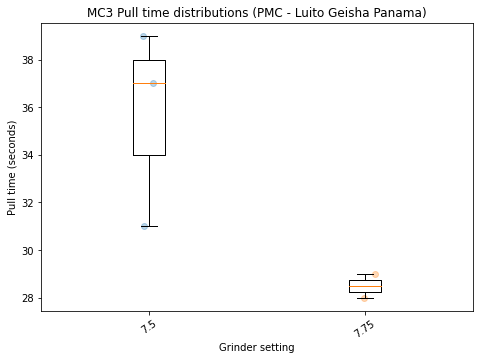

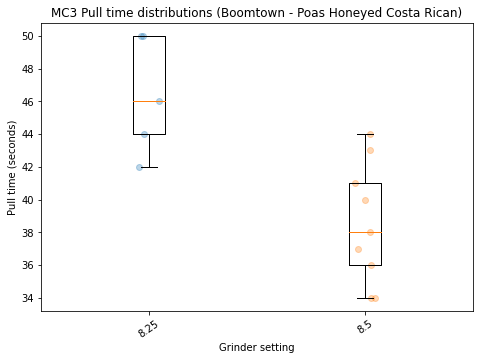

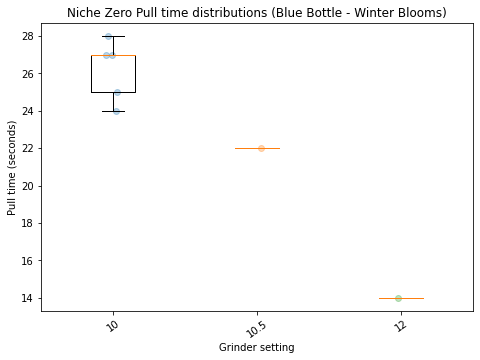

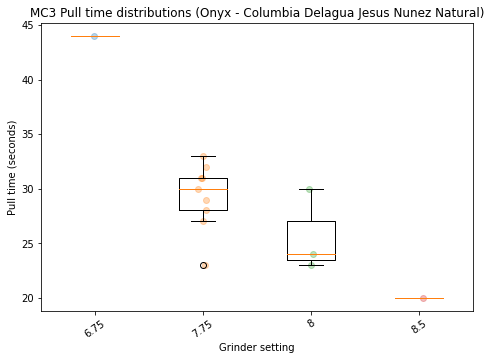

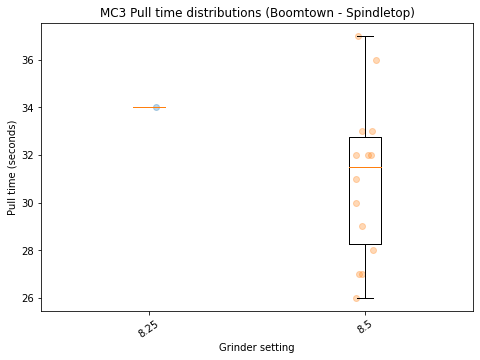

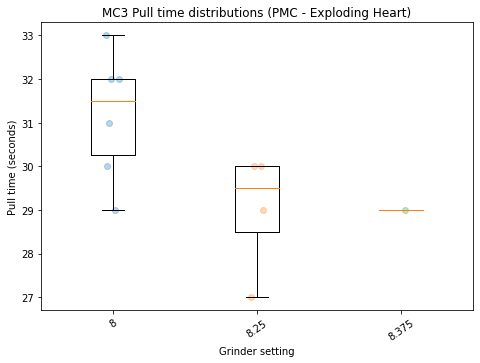

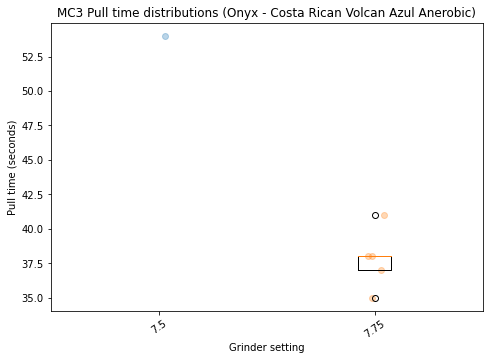

In [10]:
grinders = df.grinder.unique()
for coffee in df.coffee.unique():
    for grinder in grinders:
        columns = []
        times = []
        fig = plt.Figure()
        axe = fig.add_axes([0, 0, 1, 1])
        subdf = df[(df["grinder"] == grinder) & (df["coffee"] == coffee)]
        if subdf.empty:
            continue
        for grind in sorted(subdf.grindersetting.unique()):
            columns.append(grind)
            times.append(subdf[subdf["grindersetting"] == grind].time.tolist())

        axe.boxplot(times, labels=columns)
        i = 0
        uni_range = 0.05
        for column, vals in zip(columns, times):
            center = i+1
            axe.scatter(np.random.uniform(center - uni_range, center + uni_range, len(vals)), vals, alpha=0.3)
            i += 1
        axe.set_xticklabels(columns, rotation=35, ha='center')
        fig.suptitle('')
        axe.set_title(f"{grinder} Pull time distributions ({coffee})")
        axe.set_ylabel("Pull time (seconds)")
        axe.set_xlabel("Grinder setting")
        display(fig)